## g

In [16]:
import os
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pycocotools.coco import COCO
from skimage.feature import hog
from skimage import exposure

# Path ke file anotasi COCO dan folder gambar
annotation_file = "../dataset/Trash-COCO-Subset/train/_annotations.coco.json"
image_dir = "../dataset/Trash-COCO-Subset/train/"
valid_annotation_file = "../dataset/Trash-COCO-Subset/valid/_annotations.coco.json"
valid_image_dir = "../dataset/Trash-COCO-Subset/valid/"

# Membaca dataset COCO
coco_train = COCO(annotation_file)
coco_valid = COCO(valid_annotation_file)

# Fungsi untuk memotong gambar berdasarkan bounding box
def crop_image(image, bbox):
    x, y, w, h = map(int, bbox)
    cropped_image = image[y:y+h, x:x+w]
    
    # Pastikan gambar yang dipotong memiliki ukuran yang memadai untuk HOG
    if cropped_image.shape[0] < 32 or cropped_image.shape[1] < 32:
        return None  # Jika terlalu kecil, kembalikan None
    
    return cropped_image


# Fungsi untuk ekstraksi fitur HOG
def extract_hog_features(image):
    if isinstance(image, str):  # Jika input adalah path, baca gambar terlebih dahulu
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Pastikan gambar dalam format grayscale
    elif len(image.shape) == 3:  # Jika input adalah array gambar berwarna
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Pastikan gambar memiliki ukuran yang cukup untuk HOG
    if image.shape[0] < 32 or image.shape[1] < 32:
        return None  # Kembalikan None jika gambar terlalu kecil
    
    # Ekstraksi fitur HOG
    fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    # Normalisasi gambar HOG untuk visualisasi
    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
    
    # Pastikan panjang fitur konsisten
    return fd

# Fungsi untuk memproses data pelatihan
def process_coco_data(coco, image_dir):
    features = []
    labels = []  # Tetap menjadi list untuk menyimpan kategori
    for image_id in tqdm(coco.getImgIds(), desc="Processing images"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        for ann in annotations:
            bbox = ann['bbox']
            category_id = ann['category_id']

            # Memotong gambar berdasarkan bounding box
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                # Ekstraksi fitur HOG
                hog_features = extract_hog_features(cropped_image)
                if hog_features is not None:
                    features.append(hog_features)
                    labels.append(category_id)  # Tambahkan kategori ke daftar labels
    
    # Pastikan fitur memiliki panjang yang konsisten
    if features:
        # Memastikan semua fitur memiliki panjang yang sama
        feature_length = len(features[0])
        features = [f if len(f) == feature_length else np.zeros(feature_length) for f in features]
        
        features = np.array(features)
        labels = np.array(labels)
    return features, labels



# Proses data pelatihan
print("Processing training data...")
X_train, y_train = process_coco_data(coco_train, image_dir)

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Processing training data...


Processing images: 100%|██████████| 3170/3170 [01:34<00:00, 33.41it/s]


In [17]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Training classifier (SVM)
print("Training HOG + SVM...")
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train_encoded)

Training HOG + SVM...


SVC(kernel='linear', probability=True)

In [20]:
# Proses data validasi untuk HOG
def process_validation_data(coco, image_dir):
    features = []
    labels = []  # Tetap menjadi list untuk menyimpan kategori
    for image_id in tqdm(coco.getImgIds(), desc="Processing validation images"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        for ann in annotations:
            bbox = ann['bbox']
            category_id = ann['category_id']

            # Memotong gambar berdasarkan bounding box
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                # Ekstraksi fitur HOG
                hog_features = extract_hog_features(cropped_image)
                features.append(hog_features)
                labels.append(category_id)  # Tambahkan kategori ke daftar labels
    return np.array(features), np.array(labels)

# Proses data validasi untuk HOG
print("Processing validation data...")
X_valid, y_valid = process_validation_data(coco_valid, valid_image_dir)

# Label encoding untuk data validasi
y_valid_encoded = label_encoder.transform(y_valid)

# Prediksi menggunakan model SVM yang telah dilatih
y_pred = classifier.predict(X_valid)

# Menghitung akurasi
accuracy = accuracy_score(y_valid_encoded, y_pred)
print(f"Akurasi: {accuracy * 100:.2f}%")

# Menghitung precision, recall, dan F1-score
precision = precision_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Menampilkan confusion matrix
conf_matrix = confusion_matrix(y_valid_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Processing validation data...


Processing validation images: 100%|██████████| 312/312 [00:07<00:00, 42.46it/s]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (354,) + inhomogeneous part.

## HOG + SVM

In [1]:
import os
import numpy as np
import cv2
import json
from sklearn import svm
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

# Fungsi untuk menghitung IoU
def calculate_iou(pred_bbox, gt_bbox):
    x1, y1, x2, y2 = pred_bbox
    x1_gt, y1_gt, x2_gt, y2_gt = gt_bbox

    x1_inter = max(x1, x1_gt)
    y1_inter = max(y1, y1_gt)
    x2_inter = min(x2, x2_gt)
    y2_inter = min(y2, y2_gt)

    if x1_inter >= x2_inter or y1_inter >= y2_inter:
        return 0.0

    intersection_area = (x2_inter - x1_inter) * (y2_inter - y1_inter)
    pred_area = (x2 - x1) * (y2 - y1)
    gt_area = (x2_gt - x1_gt) * (y2_gt - y1_gt)

    union_area = pred_area + gt_area - intersection_area
    return intersection_area / union_area

# Fungsi untuk menghitung mAP
def calculate_map(y_pred_bboxes, y_pred_labels, y_pred_scores, y_true_bboxes, y_true_labels, iou_threshold=0.5):
    label_encoder = LabelEncoder()
    all_labels = np.unique([label for labels in y_true_labels for label in labels])
    label_encoder.fit(all_labels)

    average_precisions = []

    for category_id in label_encoder.classes_:
        true_positives = []
        false_positives = []
        scores = []
        total_gt = 0

        for i in range(len(y_true_bboxes)):
            gt_bboxes = y_true_bboxes[i]
            gt_labels = y_true_labels[i]
            pred_bboxes = y_pred_bboxes[i]
            pred_labels = y_pred_labels[i]
            pred_scores = y_pred_scores[i]

            matched_gt = [False] * len(gt_bboxes)

            for pred_bbox, pred_label, pred_score in zip(pred_bboxes, pred_labels, pred_scores):
                if pred_label == category_id:
                    scores.append(pred_score)
                    best_iou = 0.0
                    best_idx = -1

                    for idx, (gt_bbox, gt_label) in enumerate(zip(gt_bboxes, gt_labels)):
                        if gt_label == category_id and not matched_gt[idx]:
                            iou = calculate_iou(pred_bbox, gt_bbox)
                            if iou > best_iou:
                                best_iou = iou
                                best_idx = idx

                    if best_iou >= iou_threshold:
                        true_positives.append(1)
                        false_positives.append(0)
                        matched_gt[best_idx] = True
                    else:
                        true_positives.append(0)
                        false_positives.append(1)

            total_gt += sum(1 for label in gt_labels if label == category_id)

        if total_gt == 0:
            continue

        true_positives = np.cumsum(true_positives)
        false_positives = np.cumsum(false_positives)
        precisions = true_positives / (true_positives + false_positives + 1e-10)
        recalls = true_positives / total_gt

        average_precision = np.trapz(precisions, recalls)
        average_precisions.append(average_precision)

    return np.mean(average_precisions) if average_precisions else float('nan')

# Fungsi untuk ekstraksi fitur HOG dalam batch
def extract_hog_features_in_batches(image_paths, annotations_file, batch_size=32):
    features = []
    labels = []
    bboxes = []

    with open(annotations_file, 'r') as f:
        annotations = json.load(f)

    hog = cv2.HOGDescriptor(
        _winSize=(64, 64),
        _blockSize=(32, 32),
        _blockStride=(16, 16),
        _cellSize=(8, 8),
        _nbins=9
    )

    for i in tqdm(range(0, len(image_paths), batch_size), desc="Extracting HOG features"):
        batch_paths = image_paths[i:i + batch_size]
        for image_path in batch_paths:
            img = cv2.imread(image_path)
            if img is None:
                continue
            img = cv2.resize(img, (64, 64))
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            hog_features = hog.compute(gray).flatten()
            features.append(hog_features)

            img_name = os.path.basename(image_path)
            annotation = next(item for item in annotations['images'] if item['file_name'] == img_name)

            gt_bboxes = []
            gt_labels = []
            for ann in annotations['annotations']:
                if ann['image_id'] == annotation['id']:
                    bbox = ann['bbox']
                    x, y, w, h = map(int, bbox)
                    gt_bboxes.append([x, y, x + w, y + h])
                    gt_labels.append(ann['category_id'])

            bboxes.append(gt_bboxes)
            labels.append(gt_labels)

    return np.array(features), labels, bboxes

In [2]:
# Path ke file anotasi dan folder gambar
annotation_file = "../dataset/Trash-COCO-Subset/train/_annotations.coco.json"
image_dir = "../dataset/Trash-COCO-Subset/train/"
valid_annotation_file = "../dataset/Trash-COCO-Subset/valid/_annotations.coco.json"
valid_image_dir = "../dataset/Trash-COCO-Subset/valid/"

# Ambil daftar gambar dan ekstrak fitur HOG untuk data pelatihan
train_image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
X_train, y_train, y_train_bboxes = extract_hog_features_in_batches(train_image_paths, annotation_file)

Extracting HOG features: 100%|██████████| 100/100 [00:04<00:00, 24.58it/s]


In [3]:
# Ambil daftar gambar dan ekstrak fitur HOG untuk data validasi
valid_image_paths = [os.path.join(valid_image_dir, f) for f in os.listdir(valid_image_dir) if f.endswith('.jpg')]
X_valid, y_valid, y_valid_bboxes = extract_hog_features_in_batches(valid_image_paths, valid_annotation_file)

Extracting HOG features: 100%|██████████| 10/10 [00:00<00:00, 26.81it/s]


In [4]:
# Gabungkan semua label kategori dari data pelatihan
all_labels = [label for labels in y_train for label in labels]

# Latih label_encoder dengan semua kategori
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Menampilkan kelas yang telah di-encode
print("Encoded categories:", label_encoder.classes_)

Encoded categories: [1 2 3 4]


In [5]:
# Latih model SVM
svm_model = svm.SVC(probability=True)
# Mengonversi label ke angka untuk data pelatihan
y_train_encoded = [label_encoder.transform(labels) for labels in y_train]

# Melatih model SVM dengan data yang sudah di-encode
svm_model.fit(X_train, [labels[0] for labels in y_train_encoded])


SVC(probability=True)

In [6]:
# Prediksi pada data validasi
y_pred = svm_model.predict(X_valid)
y_pred_proba = svm_model.predict_proba(X_valid)

# Evaluasi mAP pada data validasi
print("Calculating mAP...")
mAP = calculate_map(
    y_pred_bboxes=y_valid_bboxes,
    y_pred_labels=[[y] for y in y_pred],
    y_pred_scores=y_pred_proba.tolist(),
    y_true_bboxes=y_valid_bboxes,
    y_true_labels=y_valid
)

print(f"mAP: {mAP:.4f}")

Calculating mAP...
mAP: 0.0429


In [7]:
# Prediksi untuk data validasi
y_pred_bboxes = []
y_pred_labels = []
y_pred_scores = []

for features, gt_bboxes in zip(X_valid, y_valid_bboxes):
    # Prediksi label dan probabilitas dengan SVM
    probabilities = svm_model.predict_proba([features])[0]
    predicted_label = np.argmax(probabilities)
    predicted_score = probabilities[predicted_label]

    # Untuk sementara, gunakan bounding box rata-rata dari ground truth
    if len(gt_bboxes) > 0:
        avg_bbox = np.mean(gt_bboxes, axis=0).astype(int).tolist()
    else:
        avg_bbox = [0, 0, 64, 64]  # Default bounding box jika tidak ada ground truth

    y_pred_bboxes.append([avg_bbox])
    y_pred_labels.append([predicted_label])
    y_pred_scores.append([predicted_score])


In [11]:
# Evaluasi mAP
print("Calculating mAP...")
iou_threshold = 0.5
average_precisions = []

# Untuk setiap kategori
for category_id in label_encoder.classes_:
    category_predictions = []
    category_ground_truths = []

    for image_idx, (probs, gt_data) in enumerate(zip(y_pred_scores, y_valid)):
        gt_boxes, gt_labels = gt_data  # Mengambil bounding boxes dan labels
        for bbox, gt_label in zip(gt_boxes, gt_labels):
            # Ground truth: 1 jika label cocok dengan category_id, 0 jika tidak
            category_ground_truths.append(1 if gt_label == category_id else 0)

            # Prediksi: Probabilitas untuk category_id
            if category_id < len(probs):
                category_predictions.append(probs[category_id])
            else:
                category_predictions.append(0)  # Prediksi default jika kategori tidak terdeteksi


    # Pastikan ground truth dan prediksi memiliki panjang yang sama
    if len(category_ground_truths) != len(category_predictions):
        print(f"Warning: Length mismatch for category {category_id}.")
        print(f"Ground truth length: {len(category_ground_truths)} vs Predictions length: {len(category_predictions)}")
        continue  # Lewati kategori ini jika panjangnya tidak cocok

    # Hitung Precision-Recall curve dan Average Precision
    if len(category_ground_truths) > 0 and len(category_predictions) > 0:
        precision, recall, _ = precision_recall_curve(category_ground_truths, category_predictions)
        ap = average_precision_score(category_ground_truths, category_predictions)
        average_precisions.append(ap)
    else:
        print(f"Skipping category {category_id} due to insufficient data.")

# Hitung mAP
if len(average_precisions) > 0:
    mAP = np.mean(average_precisions)
else:
    mAP = float('nan')

print(f"mAP: {mAP:.4f}")


Calculating mAP...


ValueError: not enough values to unpack (expected 2, got 1)

In [12]:
print(f"y_valid structure: {y_valid[:2]}")  # Menampilkan dua elemen pertama dari y_valid
print(f"y_pred_scores structure: {y_pred_scores[:2]}")  # Menampilkan dua elemen pertama dari y_pred_scores


y_valid structure: [[4], [4, 4]]
y_pred_scores structure: [[0.34842295806448587], [0.4552915423558484]]


## BoVW + SVMM/KNN

In [ ]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from pycocotools.coco import COCO

# Path ke file anotasi COCO dan folder gambar
annotation_file = "../dataset/Trash-COCO-Subset/train/_annotations.coco.json"
image_dir = "../dataset/Trash-COCO-Subset/train/"
valid_annotation_file = "../dataset/Trash-COCO-Subset/valid/_annotations.coco.json"
valid_image_dir = "../dataset/Trash-COCO-Subset/valid/"

# Membaca dataset COCO
coco_train = COCO(annotation_file)
coco_valid = COCO(valid_annotation_file)

# Fungsi untuk memotong gambar berdasarkan bounding box
def crop_image(image, bbox):
    x, y, w, h = map(int, bbox)
    return image[y:y+h, x:x+w]

# Fungsi untuk ekstraksi fitur SIFT
def extract_sift_features(image):
    if isinstance(image, str):  # Jika input adalah path, baca gambar terlebih dahulu
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Pastikan gambar dalam format grayscale
    elif len(image.shape) == 3:  # Jika input adalah array gambar berwarna
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(image, None)
    return descriptors

# Fungsi untuk membangun BoVW menggunakan KMeans
def build_bovw(descriptors_list, n_clusters=100):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(descriptors_list)
    return kmeans

# Fungsi untuk ekstraksi fitur BoVW
def extract_bovw_features(image_paths, kmeans):
    features = []
    valid_image_paths = []  # Menyimpan gambar yang berhasil diproses
    for image_path in tqdm(image_paths, desc="Extracting BoVW features"):
        descriptors = extract_sift_features(image_path)
        if descriptors is not None:
            # Representasikan gambar dengan histogram BoVW
            histogram = np.zeros(kmeans.n_clusters)
            labels = kmeans.predict(descriptors)
            for label in labels:
                histogram[label] += 1
            features.append(histogram)
            valid_image_paths.append(image_path)  # Menyimpan gambar yang berhasil diproses
    return np.array(features), valid_image_paths

# Proses data pelatihan untuk BoVW
def process_coco_data(coco, image_dir, kmeans):
    features = []
    labels = []  # Tetap menjadi list untuk menyimpan kategori
    for image_id in tqdm(coco.getImgIds(), desc="Processing images"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        for ann in annotations:
            bbox = ann['bbox']
            category_id = ann['category_id']

            # Memotong gambar berdasarkan bounding box
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                descriptors = extract_sift_features(cropped_image)  # Ekstraksi fitur SIFT
                if descriptors is not None:
                    histogram = np.zeros(kmeans.n_clusters)
                    cluster_labels = kmeans.predict(descriptors)  # Prediksi cluster untuk setiap deskriptor
                    for label in cluster_labels:
                        histogram[label] += 1
                    features.append(histogram)
                    labels.append(category_id)  # Tambahkan kategori ke daftar labels
    return np.array(features), np.array(labels)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [86]:
# Proses data pelatihan
print("Processing training data...")
train_image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]
all_descriptors = []
for image_path in tqdm(train_image_paths, desc="Extracting descriptors"):
    descriptors = extract_sift_features(image_path)
    if descriptors is not None:
        all_descriptors.append(descriptors)
all_descriptors = np.vstack(all_descriptors)

Processing training data...


Extracting descriptors: 100%|██████████| 3170/3170 [00:56<00:00, 56.40it/s]


In [87]:
# Membangun BoVW menggunakan KMeans
kmeans = build_bovw(all_descriptors, n_clusters=100)

In [88]:
# Proses data pelatihan untuk BoVW
X_train, y_train = process_coco_data(coco_train, image_dir, kmeans)

# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Training classifier (SVM)
print("Training BoVW + SVM...")
classifier = SVC(kernel='linear', probability=True)
classifier.fit(X_train, y_train_encoded)

Processing images: 100%|██████████| 3170/3170 [00:28<00:00, 110.08it/s]


Training BoVW + SVM...


SVC(kernel='linear', probability=True)

In [89]:
def process_coco_data_with_boxes(coco, image_dir, kmeans):
    features = []
    ground_truths = []  # Menyimpan pasangan (bounding boxes, labels)
    for image_id in tqdm(coco.getImgIds(), desc="Processing images"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        gt_boxes = []
        gt_labels = []
        for ann in annotations:
            bbox = ann['bbox']
            category_id = ann['category_id']
            gt_boxes.append(bbox)
            gt_labels.append(category_id)

            # Memotong gambar berdasarkan bounding box
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                descriptors = extract_sift_features(cropped_image)  # Ekstraksi fitur SIFT
                if descriptors is not None:
                    histogram = np.zeros(kmeans.n_clusters)
                    cluster_labels = kmeans.predict(descriptors)  # Prediksi cluster untuk setiap deskriptor
                    for label in cluster_labels:
                        histogram[label] += 1
                    features.append(histogram)
        ground_truths.append((gt_boxes, gt_labels))
    return np.array(features), ground_truths

# Evaluasi pada data validasi
print("Evaluating on validation data...")
valid_image_paths = [os.path.join(valid_image_dir, img) for img in os.listdir(valid_image_dir) if img.endswith('.jpg')]
X_valid, y_valid = process_coco_data_with_boxes(coco_valid, valid_image_dir, kmeans)

# Menghitung prediksi dan confidence
y_pred = classifier.predict(X_valid)

y_pred_proba = classifier.predict_proba(X_valid)

Evaluating on validation data...


Processing images: 100%|██████████| 312/312 [00:01<00:00, 162.36it/s]


In [105]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

# Fungsi untuk memproses data validasi dan ekstraksi fitur BoVW
def process_validation_data(coco, image_dir, kmeans):
    features = []
    labels = []  # Tetap menjadi list untuk menyimpan kategori
    for image_id in tqdm(coco.getImgIds(), desc="Processing validation images"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        for ann in annotations:
            bbox = ann['bbox']
            category_id = ann['category_id']

            # Memotong gambar berdasarkan bounding box
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                descriptors = extract_sift_features(cropped_image)  # Ekstraksi fitur SIFT
                if descriptors is not None:
                    histogram = np.zeros(kmeans.n_clusters)
                    cluster_labels = kmeans.predict(descriptors)  # Prediksi cluster untuk setiap deskriptor
                    for label in cluster_labels:
                        histogram[label] += 1
                    features.append(histogram)
                    labels.append(category_id)  # Tambahkan kategori ke daftar labels
    return np.array(features), np.array(labels)

# Proses data validasi untuk BoVW
print("Processing validation data...")
valid_image_paths = [os.path.join(valid_image_dir, img) for img in os.listdir(valid_image_dir) if img.endswith('.jpg')]
all_valid_descriptors = []
for image_path in tqdm(valid_image_paths, desc="Extracting validation descriptors"):
    descriptors = extract_sift_features(image_path)
    if descriptors is not None:
        all_valid_descriptors.append(descriptors)
all_valid_descriptors = np.vstack(all_valid_descriptors)

# Proses data validasi untuk BoVW
X_valid, y_valid = process_validation_data(coco_valid, valid_image_dir, kmeans)

# Label encoding untuk data validasi
y_valid_encoded = label_encoder.transform(y_valid)

# Prediksi menggunakan model SVM yang telah dilatih
y_pred = classifier.predict(X_valid)

# Menghitung akurasi
accuracy = accuracy_score(y_valid_encoded, y_pred)
print(f"Akurasi: {accuracy * 100:.2f}%")

# Menghitung precision, recall, dan F1-score
precision = precision_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_valid_encoded, y_pred, average='weighted', zero_division=1)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

# Menampilkan confusion matrix
conf_matrix = confusion_matrix(y_valid_encoded, y_pred)
print("Confusion Matrix:")
print(conf_matrix)


Calculating mAP...
mAP: 0.2517


Predicted bbox: [136, 164, 120.442, 72.48], label: 3, confidence: 0.37502040243080664
Predicted bbox: [138, 193, 21.111, 12.385], label: 3, confidence: 0.38322376334275243
Total predictions after thresholding: 2


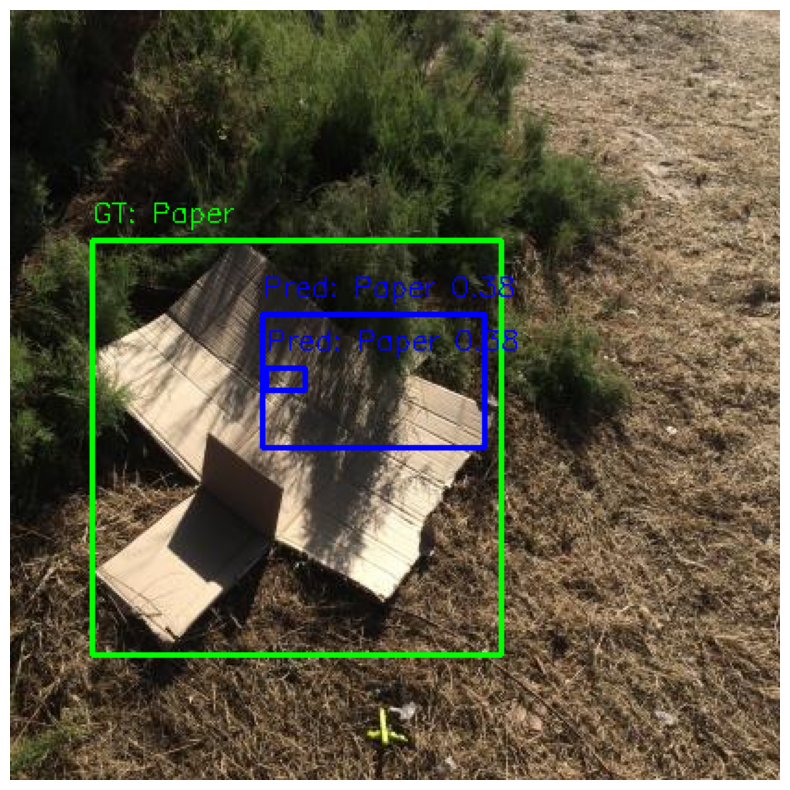

In [147]:
import matplotlib.pyplot as plt

# Fungsi untuk menggambar bounding boxes
def draw_bounding_boxes(image, ground_truths, predictions, category_map, iou_threshold=0.1):
    """
    Gambar bounding boxes pada gambar.
    Args:
        image: Gambar asli (array numpy).
        ground_truths: List dari (bbox, label) untuk ground truth.
        predictions: List dari (bbox, label, confidence) untuk prediksi.
        category_map: Peta category_id ke nama kategori.
        iou_threshold: Ambang batas IoU untuk menampilkan prediksi.
    """
    # Buat salinan gambar untuk digambar
    image_with_boxes = image.copy()
    if len(image_with_boxes.shape) == 2:  # Jika grayscale, ubah ke BGR
        image_with_boxes = cv2.cvtColor(image_with_boxes, cv2.COLOR_GRAY2BGR)

    # Gambar ground truth bounding boxes (warna hijau)
    for bbox, label in ground_truths:
        category_name = category_map.get(label, "Unknown")  # Gunakan "Unknown" jika label tidak ditemukan
        x, y, w, h = map(int, bbox)
        cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
        cv2.putText(image_with_boxes, f"GT: {category_name}", (x, y - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

    # Gambar predicted bounding boxes (warna biru)
    for bbox, label, confidence in predictions:
        if confidence > iou_threshold:  # Tampilkan hanya prediksi dengan confidence tinggi
            category_name = category_map.get(label, "Unknown")  # Gunakan "Unknown" jika label tidak ditemukan
            x, y, w, h = map(int, bbox)
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (255, 0, 0), 2)
            cv2.putText(image_with_boxes, f"Pred: {category_name} {confidence:.2f}", (x, y - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

    # Tampilkan gambar
    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

# Pilih indeks gambar
index = 7 # Ganti dengan indeks gambar yang Anda inginkan

# Ambil ID gambar dari dataset validasi
image_ids = coco_valid.getImgIds()
if index < len(image_ids):
    image_id = image_ids[index]
    image_info = coco_valid.loadImgs(image_id)[0]
else:
    raise IndexError(f"Indeks {index} tidak valid. Hanya ada {len(image_ids)} gambar.")

# Ambil path gambar
image_path = os.path.join(valid_image_dir, image_info['file_name'])
image = cv2.imread(image_path)

# Ambil ground truth bounding boxes
annotations = coco_valid.loadAnns(coco_valid.getAnnIds(imgIds=image_id))
ground_truths = [(ann['bbox'], ann['category_id']) for ann in annotations]

# Ambil prediksi dari model
predictions = []
confidence_threshold = 0.2  # Threshold confidence

for i, (bbox, label) in enumerate(zip(gt_boxes, y_pred)):
    confidence = y_pred_proba[i]  # Ambil confidence untuk bbox ke-i
    max_confidence = max(confidence)  # Ambil nilai maksimum
    print(f"Predicted bbox: {bbox}, label: {label}, confidence: {max_confidence}")
    if max_confidence > confidence_threshold:
        predictions.append((bbox, label, max_confidence))


# Debug jumlah prediksi
print(f"Total predictions after thresholding: {len(predictions)}")

# Buat peta category_id ke nama kategori
category_map = {cat['id']: cat['name'] for cat in coco_valid.loadCats(coco_valid.getCatIds())}

# Gambar bounding boxes
draw_bounding_boxes(image, ground_truths, predictions, category_map)


In [101]:
test_annotation_file = "../dataset/Trash-COCO-Subset/test/_annotations.coco.json"
test_image_dir = "../dataset/Trash-COCO-Subset/test/"

coco_test = COCO(test_annotation_file)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [121]:
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

def draw_coco_bounding_boxes(coco, image_dir, image_id, predictions=None, class_names=None, show_ground_truth=True):
    """
    Menampilkan gambar dengan bounding box dari anotasi COCO dan prediksi (jika ada).
    
    Args:
        coco (COCO): Objek COCO yang memuat anotasi.
        image_dir (str): Path ke folder gambar.
        image_id (int): ID gambar yang akan divisualisasikan.
        predictions (list, optional): Daftar prediksi bounding box [(x, y, w, h, label, confidence), ...].
        class_names (list, optional): Daftar nama kelas.
        show_ground_truth (bool, optional): Menentukan apakah akan menampilkan ground truth.
    """
    # Memuat informasi gambar
    image_info = coco.loadImgs(image_id)[0]
    image_path = os.path.join(image_dir, image_info['file_name'])
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Gambar bounding box ground truth jika diminta
    if show_ground_truth:
        ann_ids = coco.getAnnIds(imgIds=image_id)
        annotations = coco.loadAnns(ann_ids)
        for ann in annotations:
            bbox = ann['bbox']  # Format [x, y, w, h]
            category_id = ann['category_id']
            color = (0, 0, 255)  # Biru untuk ground truth
            label_text = class_names[category_id] if class_names else f"Class {category_id}"
            x, y, w, h = bbox
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
            cv2.putText(image, label_text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Gambar bounding box prediksi (jika ada)
    if predictions:
        for (x, y, w, h, label, confidence) in predictions:
            color = (0, 255, 0)  # Hijau untuk prediksi
            label_text = f"{class_names[label]}: {confidence:.2f}" if class_names else f"Class {label}: {confidence:.2f}"
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
            cv2.putText(image, label_text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Tampilkan gambar
    plt.figure(figsize=(5, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Daftar nama kelas (opsional)
class_names = {cat['id']: cat['name'] for cat in coco_test.loadCats(coco_test.getCatIds())}


Predicting bounding boxes on validation data...


Predicting bounding boxes: 100%|██████████| 110/110 [00:01<00:00, 90.21it/s]


Displaying ground truth...


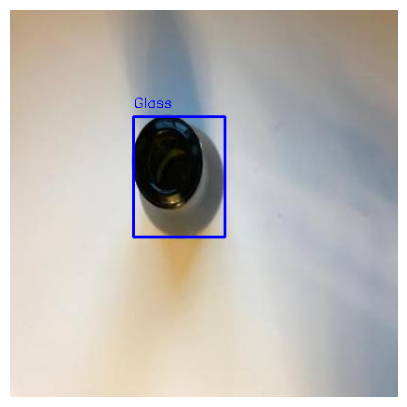

Displaying predictions...


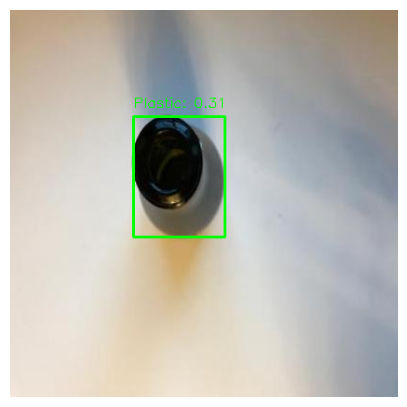

In [132]:
def predict_bounding_boxes(coco, image_dir, kmeans, classifier, label_encoder):
    predictions = {}
    for image_id in tqdm(coco.getImgIds(), desc="Predicting bounding boxes"):
        image_info = coco.loadImgs(image_id)[0]
        annotations = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
        image_path = os.path.join(image_dir, image_info['file_name'])
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            continue

        image_predictions = []
        for ann in annotations:
            bbox = ann['bbox']
            cropped_image = crop_image(image, bbox)
            if cropped_image is not None and cropped_image.size > 0:
                descriptors = extract_sift_features(cropped_image)
                if descriptors is not None:
                    histogram = np.zeros(kmeans.n_clusters)
                    cluster_labels = kmeans.predict(descriptors)
                    for label in cluster_labels:
                        histogram[label] += 1

                    histogram = histogram.reshape(1, -1)  # Bentuk ulang untuk prediksi
                    pred_label = classifier.predict(histogram)[0]
                    confidence = max(classifier.predict_proba(histogram)[0])
                    class_name = label_encoder.inverse_transform([pred_label])[0]
                    image_predictions.append((*bbox, class_name, confidence))

        predictions[image_id] = image_predictions
    return predictions

# Prediksi bounding box pada data validasi
print("Predicting bounding boxes on validation data...")
predictions = predict_bounding_boxes(coco_test, test_image_dir, kmeans, classifier, label_encoder)

# Pilih ID gambar untuk divisualisasikan
image_id = list(predictions.keys())[20]  # Pilih gambar ke-6 (misalnya)

# Gambar pertama: Ground truth
print("Displaying ground truth...")
draw_coco_bounding_boxes(coco_test, test_image_dir, image_id, class_names=class_names, show_ground_truth=True)

# Gambar kedua: Prediksi
print("Displaying predictions...")
draw_coco_bounding_boxes(coco_test, test_image_dir, image_id, predictions=predictions[image_id], class_names=class_names, show_ground_truth=False)

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
from pycocotools.coco import COCO

def draw_bounding_boxes(coco, image_path, predictions=None, class_names=None):
    """
    Menampilkan gambar dengan bounding box dari prediksi (tanpa ground truth).
    
    Args:
        coco (COCO): Objek COCO yang memuat anotasi (untuk mengambil class names).
        image_path (str): Path ke gambar yang akan divisualisasikan.
        predictions (list, optional): Daftar prediksi bounding box [(x, y, w, h, label, confidence), ...].
        class_names (list, optional): Daftar nama kelas.
    """
    # Memuat gambar
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Gambar bounding box prediksi (jika ada)
    if predictions:
        for (x, y, w, h, label, confidence) in predictions:
            color = (0, 255, 0)  # Hijau untuk prediksi
            label_text = f"{class_names[label]}: {confidence:.2f}" if class_names else f"Class {label}: {confidence:.2f}"
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
            cv2.putText(image, label_text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Tampilkan gambar
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def predict_bounding_boxes_for_new_image(image_path, kmeans, classifier, label_encoder):
    """
    Melakukan prediksi bounding box pada gambar baru yang tidak memiliki ground truth.
    
    Args:
        image_path (str): Path ke gambar yang akan diprediksi.
        kmeans (KMeans): Model KMeans untuk clustering fitur SIFT.
        classifier (SVC): Model SVM untuk klasifikasi.
        label_encoder (LabelEncoder): Label encoder untuk mengonversi label.
    
    Returns:
        list: Daftar prediksi bounding box [(x, y, w, h, label, confidence), ...].
    """
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        return []

    image_predictions = []
    # Prediksi untuk seluruh bounding box yang ada di gambar
    # Misalnya, kita anggap gambar ini mengandung objek dan kita melakukan cropping untuk setiap objek
    # Anda perlu menyesuaikan dengan cara Anda mendeteksi objek di gambar baru

    # Misalnya, menggunakan deteksi objek atau metode lain untuk mendapatkan bbox (contoh dummy)
    # Berikut adalah contoh bounding box dummy yang bisa Anda ganti dengan deteksi objek nyata
    dummy_bboxes = [(50, 50, 100, 100), (200, 200, 120, 120)]  # Ganti dengan deteksi nyata

    for bbox in dummy_bboxes:
        x, y, w, h = bbox
        cropped_image = crop_image(image, bbox)  # Crop image berdasarkan bounding box
        if cropped_image is not None and cropped_image.size > 0:
            descriptors = extract_sift_features(cropped_image)
            if descriptors is not None:
                histogram = np.zeros(kmeans.n_clusters)
                cluster_labels = kmeans.predict(descriptors)
                for label in cluster_labels:
                    histogram[label] += 1

                histogram = histogram.reshape(1, -1)  # Bentuk ulang untuk prediksi
                pred_label = classifier.predict(histogram)[0]
                confidence = max(classifier.predict_proba(histogram)[0])
                class_name = label_encoder.inverse_transform([pred_label])[0]
                image_predictions.append((x, y, w, h, class_name, confidence))

    return image_predictions

# Path gambar baru yang ingin diprediksi
image_path = 'path/to/your/image.jpg'  # Ganti dengan path gambar Anda

# Melakukan prediksi pada gambar baru
predictions = predict_bounding_boxes_for_new_image(image_path, kmeans, classifier, label_encoder)

# Menampilkan gambar dengan prediksi bounding box
draw_coco_bounding_boxes(None, image_path, predictions=predictions, class_names=class_names)


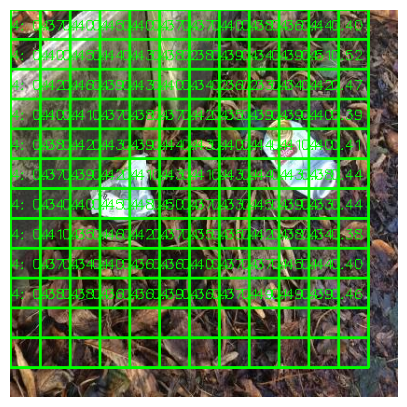

In [83]:
def process_image(image, kmeans):
    """Proses gambar untuk ekstraksi fitur BoVW."""
    if image is None:
        print("Error loading image.")
        return None
    # Ubah gambar menjadi grayscale jika belum
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    descriptors = extract_sift_features(image)
    if descriptors is not None:
        histogram = np.zeros(kmeans.n_clusters)
        cluster_labels = kmeans.predict(descriptors)
        for label in cluster_labels:
            histogram[label] += 1
        return histogram.reshape(1, -1)  # Bentuk ulang untuk prediksi
    return None

def sliding_window(image, window_size=(64, 64), step_size=32):
    """Sliding window untuk mendeteksi objek dalam gambar."""
    windows = []
    for y in range(0, image.shape[0] - window_size[1], step_size):
        for x in range(0, image.shape[1] - window_size[0], step_size):
            windows.append((x, y, window_size[0], window_size[1]))
    return windows

def predict_bounding_boxes_for_custom_image(image_path, kmeans, classifier, label_encoder):
    """Melakukan prediksi bounding box pada gambar baru."""
    # Proses gambar untuk ekstraksi fitur BoVW
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_path}")
        return []

    # Mendapatkan sliding windows
    windows = sliding_window(image)
    predictions = []

    for (x, y, w, h) in windows:
        # Potong gambar sesuai window
        cropped_image = image[y:y+h, x:x+w]
        histogram = process_image(cropped_image, kmeans)
        if histogram is None:
            continue

        # Prediksi kelas menggunakan model SVM
        pred_label = classifier.predict(histogram)[0]
        confidence = max(classifier.predict_proba(histogram)[0])
        class_name = label_encoder.inverse_transform([pred_label])[0]

        # Simpan prediksi dengan bounding box
        predictions.append((x, y, w, h, class_name, confidence))

    return predictions

def draw_bounding_boxes(image_path, predictions=None, class_names=None):
    """Menampilkan gambar dengan bounding box prediksi."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Gambar bounding box prediksi (jika ada)
    if predictions:
        for (x, y, w, h, label, confidence) in predictions:
            color = (0, 255, 0)  # Hijau untuk prediksi
            label_text = f"{label}: {confidence:.2f}" if class_names is None else f"{class_names[label]}: {confidence:.2f}"
            cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), color, 2)
            cv2.putText(image, label_text, (int(x), int(y) - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Tampilkan gambar
    plt.figure(figsize=(5, 10))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# Gambar yang ingin Anda uji
image_path = '../dataset/Trash-COCO-Subset/valid/000004_JPG.rf.255fa5adb46b1c05dc8a6df2d07428a7.jpg'  # Ganti dengan path gambar Anda

# Prediksi bounding box pada gambar kustom
predictions = predict_bounding_boxes_for_custom_image(image_path, kmeans, classifier, label_encoder)

# Menampilkan hasil prediksi pada gambar kustom
draw_bounding_boxes(image_path, predictions=predictions, class_names=None)